In [10]:
# !pip install transformers datasets accelerate
# !pip install --force-reinstall soundfile

In [8]:
import pandas as pd
import random
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer,
)
import math
import matplotlib.pyplot as plt
import numpy as np


📊 Dataset Statistics
Total facts: 5336
Train set size: 4268
Eval set size:  534
Test set size:  534

📎 Word Counts
Min: 2
Max: 4529
Mean: 187.34
Median: 150


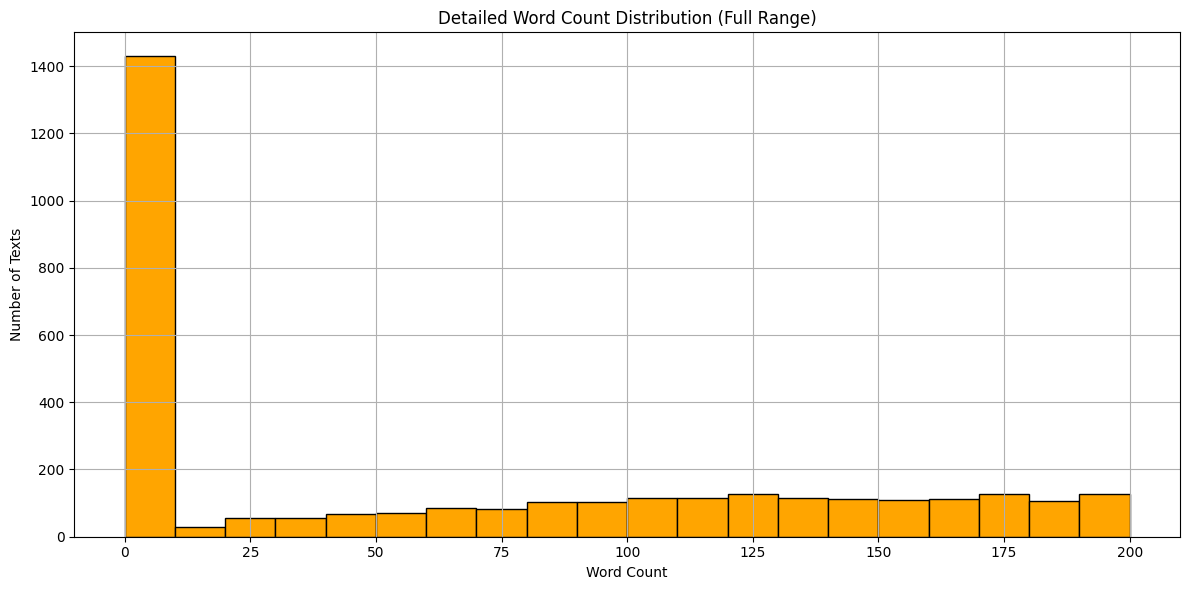

Texts with ≤ 5 words: 1417
                     verdict      extracted_gpt_facts
326          ת"פ 35512-06-17  דניאל טפרברג 54678313-/
1331             ת"פ 1158-07               ווג'די דגש
2960         תפ (נצ') 174∕03     GPT extraction error
2961         תפ (י-ם) 198∕03     GPT extraction error
2962         תפ (חי') 206∕03     GPT extraction error
...                      ...                      ...
5331         ע"ס 18387-10-09     GPT extraction error
5332         ע"ס 15660-11-09     GPT extraction error
5333       ע מ"א 27036-08-10     GPT extraction error
5334               עפ 305∕22     GPT extraction error
5335  ע מא (רמ') 21716-06-09     GPT extraction error

[1417 rows x 2 columns]


In [15]:
# ======== Load and Combine Data ========
df1 = pd.read_csv("/home/liorkob/M.Sc/thesis/data/5k/gpt/processed_verdicts_with_gpt.csv")
df2 = pd.read_csv("/home/liorkob/M.Sc/thesis/data/5k/gpt/processed_appeals_with_gpt.csv")

texts = pd.concat([
    df1["extracted_gpt_facts"].dropna(),
    df2["extracted_gpt_facts"].dropna()
]).dropna().tolist()

# ======== Shuffle and Split (80/10/10) ========
random.seed(42)
random.shuffle(texts)
n = len(texts)

train_texts = texts[:int(n*0.8)]
eval_texts = texts[int(n*0.8):int(n*0.9)]
test_texts = texts[int(n*0.9):]

# ======== Save Files ========
with open("gpt_facts.txt", "w", encoding="utf-8") as f:
    for line in train_texts:
        f.write(line.strip() + "\n")

with open("eval.txt", "w", encoding="utf-8") as f:
    for line in eval_texts:
        f.write(line.strip() + "\n")

with open("test.txt", "w", encoding="utf-8") as f:
    for line in test_texts:
        f.write(line.strip() + "\n")

# =======================
# Print Statistics
# =======================
print("📊 Dataset Statistics")
print(f"Total facts: {len(texts)}")
print(f"Train set size: {len(train_texts)}")
print(f"Eval set size:  {len(eval_texts)}")
print(f"Test set size:  {len(test_texts)}")


# Word count per fact
word_counts = [len(t.split()) for t in texts]
print("\n📎 Word Counts")
print(f"Min: {min(word_counts)}")
print(f"Max: {max(word_counts)}")
print(f"Mean: {sum(word_counts)/len(word_counts):.2f}")
print(f"Median: {sorted(word_counts)[len(word_counts)//2]}")
# Plot detailed histogram
plt.figure(figsize=(12, 6))
plt.hist(word_counts, bins=np.arange(0, 200 + 10, 10), edgecolor='black', color='orange')
plt.title("Detailed Word Count Distribution (Full Range)")
plt.xlabel("Word Count")
plt.ylabel("Number of Texts")
plt.grid(True)
plt.tight_layout()
plt.show()


short_texts = [t for t in texts if len(t.split()) <= 5]
print(f"Texts with ≤ 5 words: {len(short_texts)}")
# Filter only short ones (<= 5 words)
combined_df = pd.concat([df1, df2], ignore_index=True)

short_df = combined_df[combined_df["extracted_gpt_facts"].dropna().apply(lambda x: len(str(x).split()) <= 5)]

# Show the result
print(short_df[["verdict", "extracted_gpt_facts"]])  # or just short_df.head()


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Map:   0%|          | 0/602 [00:00<?, ? examples/s]

/home/liorkob/.conda/envs/new_env/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. D

Epoch,Training Loss,Validation Loss
1,4.771400,4.634823
2,4.632600,4.454949
3,4.045900,3.928539
4,3.263900,2.871020
5,2.310300,2.110184
6,1.838400,1.665102
7,1.529900,1.531250
8,1.462300,1.490766
9,1.421300,1.435774
10,1.357800,1.371222


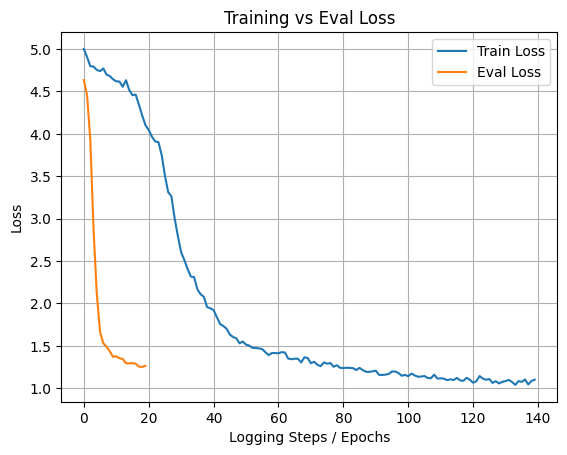

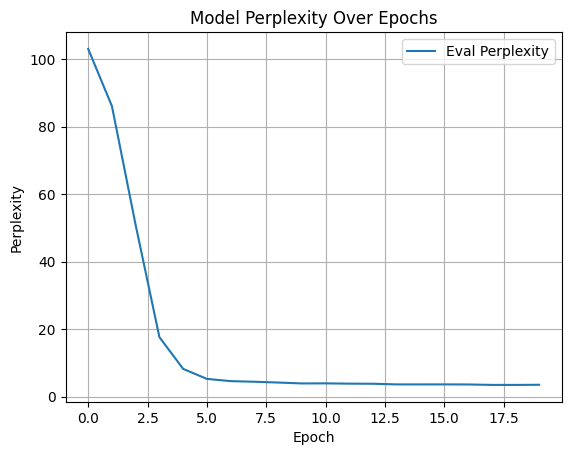

🔍 Final Test Perplexity: 3.9047409328656486


In [3]:
# ======== Load Tokenizer and Model ========
model_name = "avichr/heBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

# ======== Load Datasets ========
dataset = load_dataset("text", data_files={"train": "gpt_facts.txt"})
eval_dataset = load_dataset("text", data_files={"eval": "eval.txt"})
test_dataset = load_dataset("text", data_files={"test": "test.txt"})

# ======== Tokenization ========
def sliding_tokenize_function(examples):
    return tokenizer(
        examples["text"],
        max_length=512,
        stride=256,
        truncation=True,
        padding="max_length",
        return_overflowing_tokens=True
    )

tokenized_train = dataset.map(sliding_tokenize_function, batched=True, remove_columns=["text"])
tokenized_eval = eval_dataset.map(sliding_tokenize_function, batched=True, remove_columns=["text"])
tokenized_test = test_dataset.map(sliding_tokenize_function, batched=True, remove_columns=["text"])

# ======== Training Arguments ========
training_args = TrainingArguments(
    output_dir="./hebert-mlm-verdicts",
    logging_dir="./hebert-mlm-verdicts/logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    save_steps=500,
    logging_steps=100,
    evaluation_strategy="epoch",
    save_total_limit=2
)

# ======== Data Collator for MLM ========
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

# ======== Trainer ========
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train["train"],
    eval_dataset=tokenized_eval["eval"],
    data_collator=data_collator
)

# ======== Training ========
trainer.train()
trainer.save_model("./hebert-mlm-verdicts/final")
tokenizer.save_pretrained("./hebert-mlm-verdicts/final")

# ======== Plots ========
log_history = trainer.state.log_history
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]

plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Eval Loss")
plt.xlabel("Logging Steps / Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Eval Loss")
plt.grid(True)
plt.show()

perplexities = [math.exp(loss) for loss in eval_loss]
plt.plot(perplexities, label="Eval Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Model Perplexity Over Epochs")
plt.grid(True)
plt.legend()
plt.show()

# ======== Final Test Evaluation ========
test_results = trainer.evaluate(eval_dataset=tokenized_test["test"])
print("🔍 Final Test Perplexity:", math.exp(test_results["eval_loss"]))


In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  

def get_token_count(example):
    return {"token_count": len(tokenizer(example["text"], add_special_tokens=True)["input_ids"])}

total_tokens = 0
total_texts = 0

for split_name, split_dataset in dataset.items():
    tokenized_dataset = split_dataset.map(get_token_count)
    split_total = sum(tokenized_dataset["token_count"])
    split_count = len(tokenized_dataset)

    avg = split_total / split_count
    print(f"{split_name} - ממוצע טוקנים: {avg:.2f}")

    total_tokens += split_total
    total_texts += split_count

print(f"\nסה\"כ ממוצע טוקנים בכל הדאטה: {total_tokens / total_texts:.2f}")


Map:   0%|          | 0/4389 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1538 > 512). Running this sequence through the model will result in indexing errors


train - ממוצע טוקנים: 818.41

סה"כ ממוצע טוקנים בכל הדאטה: 818.41


In [15]:
# הערכה וחישוב Perplexity
eval_results = trainer.evaluate(eval_dataset=tokenized_eval["eval"])
perplexity = math.exp(eval_results["eval_loss"])
print("Perplexity:", perplexity)


Perplexity: 46.996285618025105


## baseline 

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

baseline_model = AutoModelForMaskedLM.from_pretrained("avichr/heBERT")
baseline_tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT")
from datasets import load_dataset

test_dataset = load_dataset("text", data_files={"test": "test.txt"})
def sliding_tokenize_function(examples):
    return baseline_tokenizer(
        examples["text"],
        max_length=512,
        stride=256,
        truncation=True,
        padding="max_length",
        return_overflowing_tokens=True
    )

tokenized_test = test_dataset.map(sliding_tokenize_function, batched=True, remove_columns=["text"])
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
import math

data_collator = DataCollatorForLanguageModeling(
    tokenizer=baseline_tokenizer, mlm=True, mlm_probability=0.15
)

baseline_trainer = Trainer(
    model=baseline_model,
    args=TrainingArguments(output_dir="./baseline", per_device_eval_batch_size=8),
    eval_dataset=tokenized_test["test"],
    data_collator=data_collator
)

baseline_results = baseline_trainer.evaluate()
print("📉 Baseline Perplexity:", math.exp(baseline_results["eval_loss"]))
